### Objectives:

- To compute the empirical and the theoretical probabilities of an event.
- To plot the empirical histogram and the pmf of a discrete random variable.
- To compute the empirical and the theoretical mean values of a discrete random variable.

The following code imports necessary libraries and defines some classes, which will be used below. You can skip this part and start reading from the Introduction.

In [1]:
import numpy as np
import scipy.stats 
import matplotlib.pyplot as plt

class source:
    '''source creating messages'''
    
    def __init__(self, p = 0.5, nbits = 20):
        '''initialize the source'''
        self.p = p # probability each bit is a 1
        self.nbits = nbits # number of bits in the message
        
    def message(self):
        '''create message'''
        return list(1*(np.random.rand(self.nbits) > self.p))
    
class binary_channel:
    '''binary channel for a bitstream of 1's and zeros'''
    
    def __init__(self, p_error = 0.1):
        '''initialize as symmetric channel'''
        self.p_error1 = p_error # probability of error if input bit is 1
        self.p_error0 = p_error # probability of error if input bit is 0
        
    def set_assymmetric(self, p_error0, p_error1):
        '''set channel to be assymetric'''
        self.p_error1 = p_error1
        self.p_error0 = p_error0
    
    def transmit(self, input_bitstream):
        '''transmit an input bitstream'''
        
        output_bitstream = []
        for b in input_bitstream:
            if b == 1:
                output_bitstream.append( 1 * (np.random.rand() >= self.p_error1) )
            else:
                output_bitstream.append( 1 * (np.random.rand() < self.p_error0) )
        return output_bitstream

def count_errors(msg_in, msg_out):
    '''count number of bit errors between two messages'''
    
    return sum( np.array(msg_in) != np.array(msg_out) )

class repetition_coder():
    '''repetition code channel coder'''
    
    def __init__(self, code_length = 1):
        '''initialize'''
        self.code_length = code_length # length of repetition code
        
    def encode(self, input_msg):
        '''encode message'''        
        output_msg = [] # create output message
        for b in input_msg: # loop over each bit in the input message
            output_msg.extend([b]*self.code_length) # repeat each bit code_length times
        return output_msg
    
    def decode(self, input_msg):
        '''decode message'''
        output_msg = []
        for i in range(0, len(input_msg), self.code_length):
            output_msg.append( 1 * (sum(input_msg[i:i+self.code_length]) > self.code_length/2.0) )
        return output_msg
    
class tcp_connection:
    '''transmission control protocol connection for reliable transport'''
    
    def __init__(self, coder = None, channel = None):
        '''initialize'''
        if coder == None:
            self.coder = repetition_coder()
        else:
            self.coder = coder
        if channel == None:
            self.channel = binary_channel()
        else: 
            self.channel = channel
    
    def transmit(self, message = [], verbose = False):
        '''transmit message'''
        if len(message) == 0: # check if message exists
            raise Exception('Length of message must be nonzero')
        
        bitstream = self.coder.encode(message) # create bitstream to transmit

        xmit_count = 1 # counts number of transmit attempts until success
        
        # loop to transmit message until success
        success = False
        while not (success):
            if verbose: print(f'Transmit attempt {xmit_count}: ')
            received_bitstream = self.channel.transmit(bitstream) # transmit message
            received_message = self.coder.decode(received_bitstream) # decode message
            num_errors = count_errors(message, received_message) # check if error free
            if num_errors == 0:
                if verbose: print(f'Success!')
                success = True
            else:
                if verbose: print(f'Failed! {num_errors} bit errors')
                xmit_count += 1
            if xmit_count > 1000:
                print('Maximum number of transmissions exceeded.')
                print(f'Setting number of transmissions to {xmit_count}.')
                success = True
        
        return xmit_count       

## Introduction

This notebook simulates a communcation system that has many similarities to the way we transmit email. Recieved email needs to be 100% accurate, but transmission over the internet is unreliable (noisy) and can introduce errors. Thus, in order to make sure received email is correct, the receiver has a way of detecting errors in a received email, and will ask the sender to re-send the email if it detects an error. The sender will keep sending the email until it is received correctly. Thus over an unreliable channel, an email may need to be sent many times, depending upon the probability that the email is received correctly. The lower this probability, the more times the email may need to be sent.

### Random bitsteams as messages

Emails are encoded as bitstreams (sequences of 1's and 0's). In this notebook, we will model an email as a random sequence of __nbits__ bits. Objects in the "source" class can create random bitstreams with varying lengths, as shown below. You can try changing the value assigned to **nbits**, and re-running the cell.

In [2]:
src = source(nbits = 10) # create a source of random 10 bit bitstreams

msg = src.message() # generate a message (bitstream) from the source

print(f'This is the random message generated : {msg}')

This is the random message generated : [1, 0, 1, 1, 0, 1, 0, 1, 1, 0]


### Binary Channel Model

One of the most common ways to model unreliable transmission of bitstreams is called the symmetric binary channel model. In this case, bits in the bitstream are flipped with some probability __p_error__. The following code creates a binary channel and transmits a random bitstream through it. 

In [3]:
src = source(nbits = 10) # create a source of random 10 bit bitstreams

msg = src.message() # generate a message (bitstream) from the source
print(f' Input message = {msg}')

ch1 = binary_channel(p_error = 0.5) # create a binary channel with 0.5 probability of error

output_msg = ch1.transmit(msg) # transmit the message through the channel
print(f'Output message = {output_msg}')

errors = list( 1 * (np.array(msg) != np.array(output_msg)) ) # identify which bits have errors
print(f'        Errors = {errors}')

num_errors = count_errors(msg, output_msg)
print(f'Number of errors: {num_errors}') # count the number of errors

 Input message = [0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
Output message = [1, 0, 0, 0, 1, 0, 1, 1, 1, 1]
        Errors = [1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
Number of errors: 6


### Channel Coding

One of the most common ways to increase the reliability of a communcation channel is called channel coding: adding additional bits to the message. The easiest way to do this is called a *repetition code*. We simply take each bit and repeat it a number (__code_length__) of times. The repetition_coder class creates channel coders that can encode and decode messages with varying code lengths. Try changing the value assigned to **code_length** to see its effect.

In [4]:
coder = repetition_coder(code_length = 3) # create a coder that repeats each bit code_length times

msg = [1, 0, 1] # create input message

coded_msg = coder.encode(msg) # encode the message

# compare the original and encoded messages
print(f'After repetition coding, the message {msg} is encoded as {coded_msg}.')

After repetition coding, the message [1, 0, 1] is encoded as [1, 1, 1, 0, 0, 0, 1, 1, 1].


In order to decode the message, we use majority voting. More precisely, we break the received wavefrom up into blocks of __code_length__ bits and count the number of 1's. If there are more ones than zeros (the number of 1's is greater than __code_length__/2), then we assume the transmitted bit was a 1, otherwise, we assume it was a 0. This enables correct transmission, even if a few bit errors creep in, as shown below. However, the transmitted bitstream is much longer than the original.

In [5]:
coder = repetition_coder(code_length = 3) # create a repetition coder that repeats each bit 3 times

# create a message
msg = [1, 0, 1]
print(f'  The original message is {msg}.')

# use the repetition encoder to encode it
coded_msg = coder.encode(msg) # encode a 3 bit bitstream
print(f'After repetition coding : {coded_msg}.')

# flip two bits in the waveform
coded_msg[1] = 1-coded_msg[1]
coded_msg[5] = 1-coded_msg[5]
print(f' After bit errors added : {coded_msg}.')

# use the coder to decode the corrupted bitstream
decoded_msg = coder.decode(coded_msg) # decode the corrupted bitstream

# print results
print(f'  The received message is {decoded_msg}. (Same as original!)')

  The original message is [1, 0, 1].
After repetition coding : [1, 1, 1, 0, 0, 0, 1, 1, 1].
 After bit errors added : [1, 0, 1, 0, 0, 1, 1, 1, 1].
  The received message is [1, 0, 1]. (Same as original!)


### Reliable transmission through TCP

Although we can use repetition coding to reduce errors, we cannot eliminate them entirely. Thus, in order to ensure reliable transmissions, emails are transmitted using the Transmission Control Protocol (TCP). An email is sent repeatedly until it is received correctly.  The code below creates a noisy channel and uses the TCP protocol to transmit a message over that channel. The verbose flag in the transmit method triggers the method to tell you what happens with each transmission attempt, i.e. whether the attempt succeeded or failed, and the number of bit errors  if there was a failure.

In [6]:
src = source(nbits = 10) # create message source
ch = binary_channel(p_error = 0.15) # create noisy binary channel 

tcp1 = tcp_connection(channel = ch) # create a tcp connection called tcp1

msg = src.message() # generate a message

num_xmit = tcp1.transmit(message = msg, verbose = True) # transmit message over the tcp_connection tcp1

# print results
print(f'The number of transmissions required until a successful transmission was {num_xmit}.')

Transmit attempt 1: 
Failed! 1 bit errors
Transmit attempt 2: 
Failed! 1 bit errors
Transmit attempt 3: 
Failed! 1 bit errors
Transmit attempt 4: 
Failed! 1 bit errors
Transmit attempt 5: 
Failed! 4 bit errors
Transmit attempt 6: 
Failed! 3 bit errors
Transmit attempt 7: 
Failed! 1 bit errors
Transmit attempt 8: 
Success!
The number of transmissions required until a successful transmission was 8.


### Combining Channel Coding with TCP

We can improve the reliability of the channel by adding repetition coding. This increases the length of each transmitted message, but generally reduces the number of attempts before a successful transmission. TCP transmission with a channel coder that repeats each bit 3 times is simulated below.

In [7]:
src = source(nbits = 10) # create message source
ch = binary_channel(p_error = 0.15) # create noisy binary channel 

rep3 = repetition_coder(code_length = 3) # create a repetition coder

# create tcp connection over the channel using repetition coding
tcp3 = tcp_connection(channel = ch, coder = rep3) 

num_xmit3 = tcp3.transmit(message = msg, verbose = True) # transmit message

# print resuts
print(f'The number of transmissions require until a successful transmission was {num_xmit3}.')

Transmit attempt 1: 
Failed! 1 bit errors
Transmit attempt 2: 
Success!
The number of transmissions require until a successful transmission was 2.


Try running the two code cells above several times. Because the system is random, sometimes the first system will require fewer transmissions than the second. Probability cannot tell us much about any particular outcome or trial. However, it can tell us about what happens in average. On average, we expect the number of transmissions required for the first case to be larger than the number of transmissions required in the second case.

Does increasing the repetition rate result in a net increase or decrease in the number of bits that need to be transmitted on average for successful transmission?  Is there an optimal length of the repetition code that minimizes the number of bits transmitted on average? How does this depend upon the length of the email that needs to be transmitted? How does the probability of error in the binary channel? What if we make the channel assymetric (different probabilities of errors for 0 and 1)? All of these questions can be answered using computer simulation anf with probability theory, as we show in more detail below.

### Useful probability distributions

In network communcations, discrete probability distributions are very useful. In class, we have studied a number of discrete probablity distributions, including the binomial, geometric and Poisson.  Python includes classes enabling us to compute various quantities relating to these in the **scipy.stats** library. Useful methods associated with these classes are the **pmf** method and the **mean** method, the use of which are illustrated below.

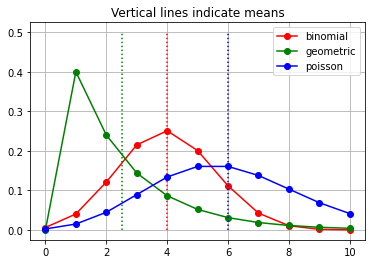

In [8]:
from scipy.stats import binom # binomial distribution
from scipy.stats import geom # geometric distribution
from scipy.stats import poisson # Poisson distribution

n = 10 # number of trials in binomial distribution
p = 0.4 # probability of success in 
mu = 6 # mu (also often called lambda) parameter of the Poisson distribution

npts = 10
x = np.arange(0,npts+1) # range of plots
pmfs = np.zeros((3,npts+1))
pmfs[0,:] = binom.pmf(x, n=n, p=p) # binomial pmf
pmfs[1,:] = geom.pmf(x, p=p) # geometric pmf
pmfs[2,:] = poisson.pmf(x, mu=mu) # Poisson pmf

means = np.zeros(3)
means[0] = binom.mean(n=n, p=p) # mean of binomial RV
means[1] = geom.mean(p=p) # mean of binomial RV
means[2] = poisson.mean(mu=mu) # mean of binomial RV

labels = ('binomial','geometric','poisson')
colors = ('r','g','b')

fig, ax = plt.subplots() # create a figure and a set of axes
# plot the three distributions using a for loop
for i in range(0,3):
    ax.plot(x, pmfs[i,:], '-o', label = labels[i], color = colors[i]) # plot the pmf
    ax.plot(means[i]*np.ones(2),[0, 0.5], ':', color = colors[i]) # plot a dotted vertical line for the mean
ax.legend() # add a plot legend
ax.set_title('Vertical lines indicate means') # set the title
ax.grid() # show a grid
plt.show() # show the plot

## Part a: Number of bit errors in a single block of bits

What if we transmit a block of 11 bits (or more generally n bits)  over a noisy channel? What is the distribution of the number of bit errors in the block? What is the average number of bit errors? This situation can be described using the binomial distribution, which is available in the class **binom** from the **scipy.stats** library.

The following code simulates the transmission of a block of 11 bits over a noisy channel many times, and keeps a record of the number of errors that occur in each trial. The code plots a histogram of the number of errors, and compares it to the probability mass function of the binomial random variable.

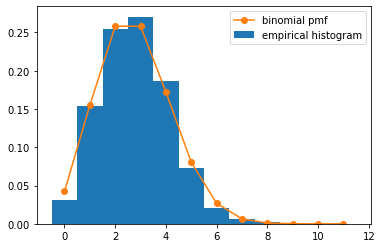

In [9]:
# create source
num_bits = 11 # number of bits in a block
src = source(nbits = num_bits) # create source

# create channel
p = 0.25 # probability of error
ch = binary_channel(p_error = p) # create channel

# run the simulations
num_trials = 2000 # number of trials to run
error_record = np.zeros(num_trials) # create numpy array to hold record of bit errors
for i in range(0,num_trials):
    msg = src.message() # create a random message
    received = ch.transmit(msg) # transmit it over the channel
    error_record[i] = count_errors(msg, received) # count and record the number of errors

# calculate the theoretical prediction
x = np.arange(0,num_bits+1) # values at which to calculate the pmf
y = binom.pmf(x, num_bits, p) # the values of the pmf

# create plot
fig, ax = plt.subplots() # create figure and axes to plot into

# plot the histogram
bin_edges = np.arange(-0.5,num_bits+1,1) # create edges of the histogram bins at -0.5, 0.5, 1.5, ...
ax.hist(error_record, bins = bin_edges, density = True, label='empirical histogram')

# plot the theoretical prediction
ax.plot(x, y, '-o', label = "binomial pmf")

# add legend and show plot
ax.legend()
plt.show()

From the record of bit errors generated in the simulations above, calculate the relative frequency that the number of bit errors is more than half the total number of bits in the block. 

In [10]:
# put your code here


Use the binomial pmf to calculate the numerical value of the theoretical probability that more than half the bits in the block are received in error. This should be close to the relative frequency you calculated above.

In [11]:
# put your code here


## Part b: Number of transmissions required by TCP

As discussed above, TCP connections retransmit messages until the first success: an error free transmission. We define that an error free transmission occurs when the received message (after decoding by the channel coder if any) is identical to the original message, i.e. there are no bit errors in the message.

Suppose we are running a TCP transmitter that is transmitting messages over a channel that introduces bit errors with probablity **p**. The messages are random bitstreams of length **num_bits**. No repetition coding is used.  What probability distribution describes the number of transmissions required until the message is successfuly transmitted? What is(are) the parameter(s) of that distribution?

To answer this question, write code that simulates a TCP connection **num_trials** times. Keep a record of the number of attempts until a successful transmission. Plot the pmf of the probability distribution with the correct parameter(s), and compare it with the empirical histogram. 

Use the following values: **p** = 0.1, **num_bits** = 11, **num_trials** = 1000

**Hints:**

This task is very similar to what was done for the number of bit errors in Part a

Compute the histogram with the **bins** assigned, and plot the pmf at the values **x** assigned below.

Note that the **transmit** method of the **tcp_connection** object returns the number of attempts until a successful transmission. Also, when running the simulation, set __verbose = False__ during **transmit**, to suppress the text output and avoid clutter.  

Since we will assume that there is no channel coder, the code for running the TCP connection is similar to the case in the section "Reliable Coding with TCP" above.

If you need more help, you may find it helpful to peek ahead to the inner loop of the code in **Part c**.

In [12]:
# use this variable for the bins of the histogram
bin_edges = np.arange(-0.5,16,1) # create bin edges at -0.5, 0.5, 1.5, ...
# plot the pmf at these values
x = np.arange(0,16)

# put your code here


Find the average number of transmissions required until the message is successfully transmitted in your simulations. Compare this with the theoretical prediction from the pmf you used to model the empirical histogram. 

In [13]:
# put your code here



## Part c: Average number of bits required to transmit successfully.

As discussed above, if we use repetition coding, the probability that a message gets through without errors increases. This decreases the number of times on average we need to transmit the message. However, the length of the message increases. 

Does the decrease in the number of transmissions offset the increase in the length of the bits? The following code investigates this by running a simulation where we keep track of the average number of bits transmitted until a successful transmission for a number of repetition code lengths. For each successful transmit, the number of bits required is equal to the number of bits in the message times the repetition code length times the number of transmission attempts required.  We also compare the simulation model to a simple theoretical model that assumes the first transmission attempt is always successful, i.e. the number of bits required is equal to the number of bits in the message times the repetition code length.

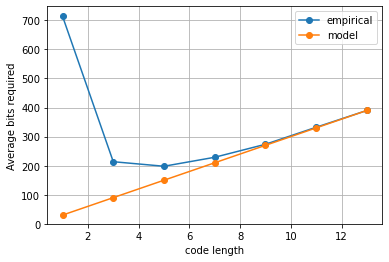

In [14]:
num_trials = 300 # number of trials to run
num_bits = 30 # number of bits in the message block
p = 0.1 # probability of a bit error

src = source(nbits = num_bits) # create message source
ch = binary_channel(p_error = p) # create binary channel

# run the simulations for multiple code lengths
code_lengths = np.arange(1,15,2) # create an array of code lengths
bits_required = np.zeros(np.size(code_lengths)) # create an array to store the average number of bits required
model = np.zeros(np.size(code_lengths)) # create an array to store the model predictions
transmit_record = np.zeros(num_trials) # create an array to store the number of transmit attempts

# loop over code lengths
for j in range(0, len(code_lengths)): 

    coder = repetition_coder(code_length = code_lengths[j]) # create a repetition coder
    tcp = tcp_connection(channel = ch, coder = coder) # create a tcp connection 
    
    # loop over trials
    for i in range(0,num_trials): # run multiple transmissions
        msg = src.message() # create a random message
        transmit_record[i] = tcp.transmit(message = msg, verbose = False) # record how many attempts
    
    # calculate average number of bits required
    bits_required[j] = num_bits * code_lengths[j] * np.average(transmit_record) 
    model[j] = num_bits * code_lengths[j]

# create plot
fig, ax = plt.subplots()
ax.plot(code_lengths, bits_required, '-o', label = "empirical") # plot empirical results
ax.plot(code_lengths, model, '-o', label = "model") # plot model
ax.legend() # show legend
ax.set_ylabel('Average bits required') # set y axis label
ax.set_xlabel('code length') # set x axis label
ax.set_ylim(bottom=0.0) # start y axis from 0 at the bottm
ax.grid() # show grid
plt.show() # show plot

From the simulation above, you can see that repetition coding does help, up to a certain point. However, after a while, the increase in the number of bits transmitter per message does not decrease the probability of error in the message to make it worthwhile. 

We also see that our simple model actually works pretty well for larger code lengths, but not so well for shorter code lengths.

Can you use your knowledge of probability and what you learned above to improve upon the predictions of the simple model?

Modify the code for the model in the cell below so that you make a theoretical prediction that matches the empirical results better at both long and short code lengths. 

The code in this cell depends on the results of the previous cell, so if you somehow corrupt the variables in the environment you may need to re-run the cell above to reset the variables to their correct values.

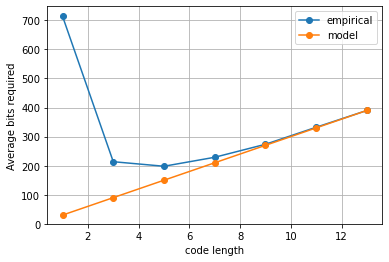

In [15]:
for j in range(0, len(code_lengths)): # loop over code lengths
    
    # modify the code below
    model[j] = num_bits * code_lengths[j]
    
# create plots -- DO NOT CHANGE THIS CODE
fig, ax = plt.subplots()
ax.plot(code_lengths, bits_required, '-o', label = "empirical")
ax.plot(code_lengths, model, '-o', label = "model")
ax.legend()
ax.set_ylabel('Average bits required')
ax.set_xlabel('code length')
ax.set_ylim(bottom=0.0)
ax.grid()
plt.show()